In [36]:
import rebound
import reboundx
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
import re
from numpy.random import seed, normal, uniform
from numpy.testing import assert_approx_equal

sys.path.append('../')

from ic import output, initialize, plotsa, removedamping, plot, integrate

In [5]:
from collections import OrderedDict
planets = ['b', 'c', 'd', 'e', 'f', 'g', 'h']
resonances = OrderedDict([(('b','c'),(8,5)),(('c','d'),(5,3)),(('d','e'),(3,2)),(('e','f'),(3,2)),(('f','g'),(4,3)),(('g','h'),(3,2))]) # ordered so we add planets in right sequence
threebodyresonances = OrderedDict([(('b','c','d'),(2,3)),(('c','d','e'),(1,2)),(('d','e','f'),(2,3)),(('e','f','g'),(1,2)),(('f','g','h'),(1,1))])

b 5.891728565705365
c 9.432216354043426
d 15.732166223739089
e 23.61602363289151
f 35.464710782314505
g 47.356809949108445
h 71.21659288829233
('b', 'c') 1.6009251357821488
('c', 'd') 1.6679182954698644
('d', 'e') 1.5011298060947293
('e', 'f') 1.501722361630795
('f', 'g') 1.3353220399790846
('g', 'h') 1.5038300291937858


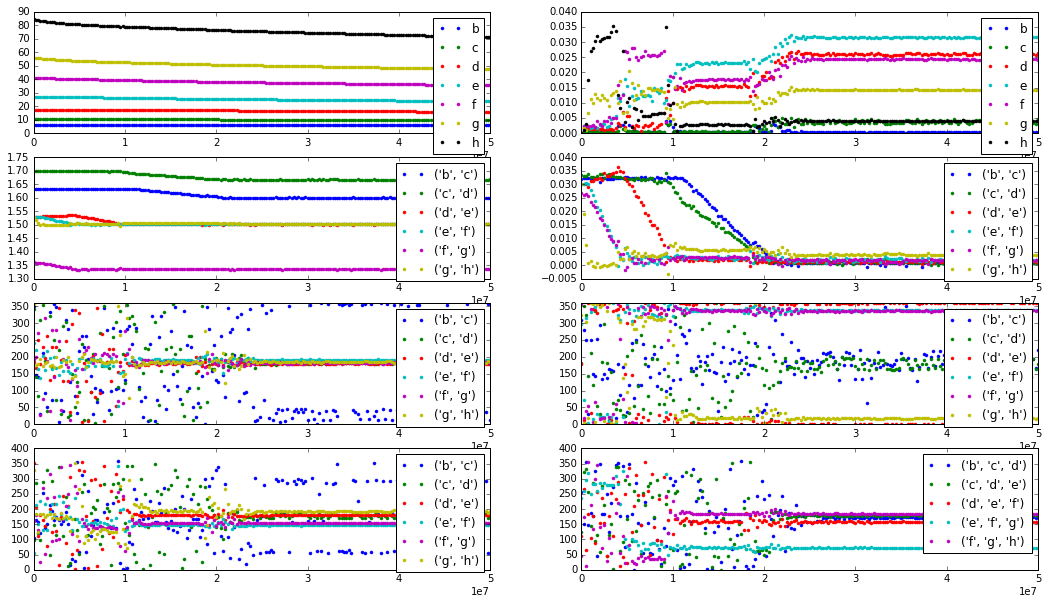

In [7]:
simID = 0

path = '../makeic/data/'
for filename in os.listdir(path):
    if filename.startswith("IC{0}K".format(simID)):
        sa = rebound.SimulationArchive(path+filename)
        plotsa(sa,planets,resonances,threebodyresonances, loc='upper right');
        break

In [42]:
Nruns = 2
df = pd.DataFrame(columns=('K', 'mag'))

path = '../makeic/data/'
outputs = initialize(planets, resonances, threebodyresonances)

for simID in [3,7]:
    for filename in os.listdir(path):
        result = re.search('IC(.*)K(.*).bin', filename)
        if result:
            ID = int(result.group(1))
            if ID == simID:
                K = result.group(2)
                df.loc[simID] = [K,3]
            
df.head()
df.to_csv('testdf.csv')

True


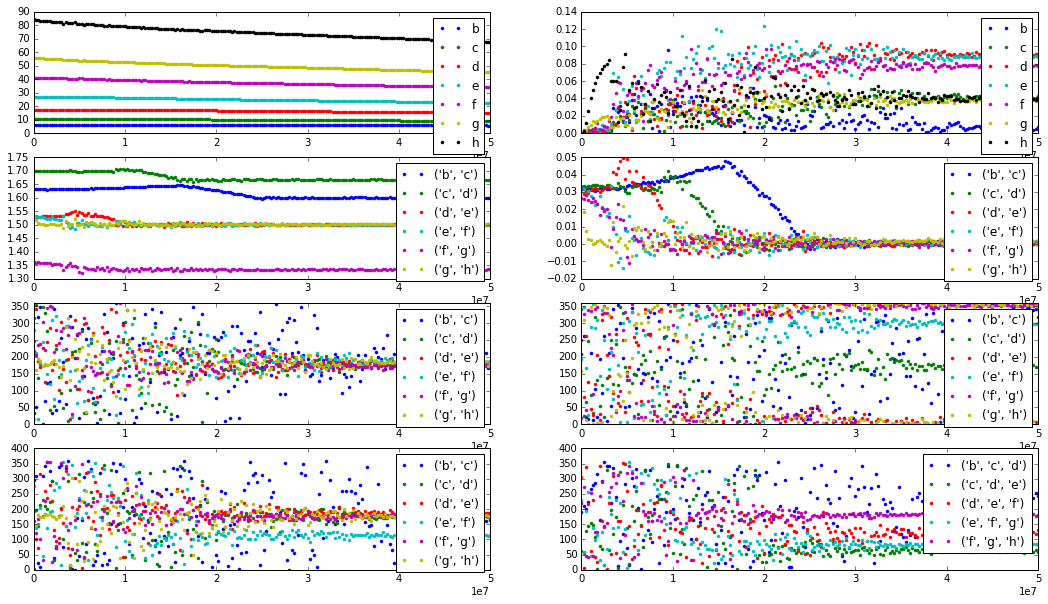

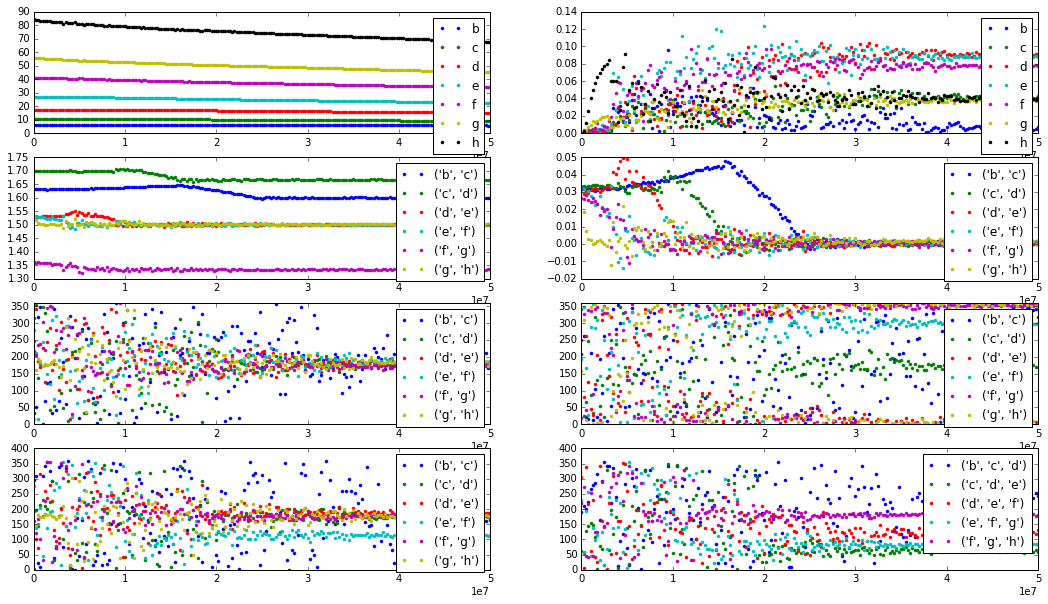

In [71]:
simID = 7

frac = 0.2 # take last x fraction of samples to check for resonance
pratiothresh = 0.02

path = '../makeic/data/'
outputs = initialize(planets, resonances, threebodyresonances)
        
for filename in os.listdir(path):
    result = re.search('IC(.*)K(.*).bin', filename)
    if result:
        ID = int(result.group(1))
        if ID == simID:
            K = float(result.group(2))
            sa = rebound.SimulationArchive(path+filename)
            plotsa(sa,planets,resonances,threebodyresonances, loc='upper right');
            Nout = len(sa)
            N = sa[0].N
            for i,sim in enumerate(sa):
                ps = sim.particles
                output(sim,planets,resonances,threebodyresonances,outputs)

            t, e, P, Pratio, phi1, phi2, deltapomega, phi3body = outputs

            success = True
            for resonance in resonances.items():
                pair = resonance[0]
                res = resonance[1]
                resratio = res[0]/res[1]
                startindex = -int(len(Pratio[pair])*frac)
                pratio = np.array(Pratio[pair][startindex:])
                if abs((pratio.mean()-resratio)/resratio) > pratiothresh:
                    print("{0} pair not in {1} resonance. Mean period ratio = {2}".format(pair, res, pratio.mean()))
                    success = False

            plotsa(sa,planets,resonances,threebodyresonances, loc='upper right');
            print(success)

In [73]:
K

14.211

In [74]:
sim = sa[-1]
ps = sim.particles

rebx = reboundx.Extras(sim)
params = rebx.add("modify_orbits_forces")

taua = 5.e7
taue = taua/K

for p in ps[1:]:
    p.params["tau_e"] = -taue
ps['h'].params["tau_a"] = -taua

/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:508: RuntimeWarning: REBOUNDx: Passing a velocity-dependent force to WHFAST. Need to apply as an operator.
  warnings.warn(msg[1:], RuntimeWarning)


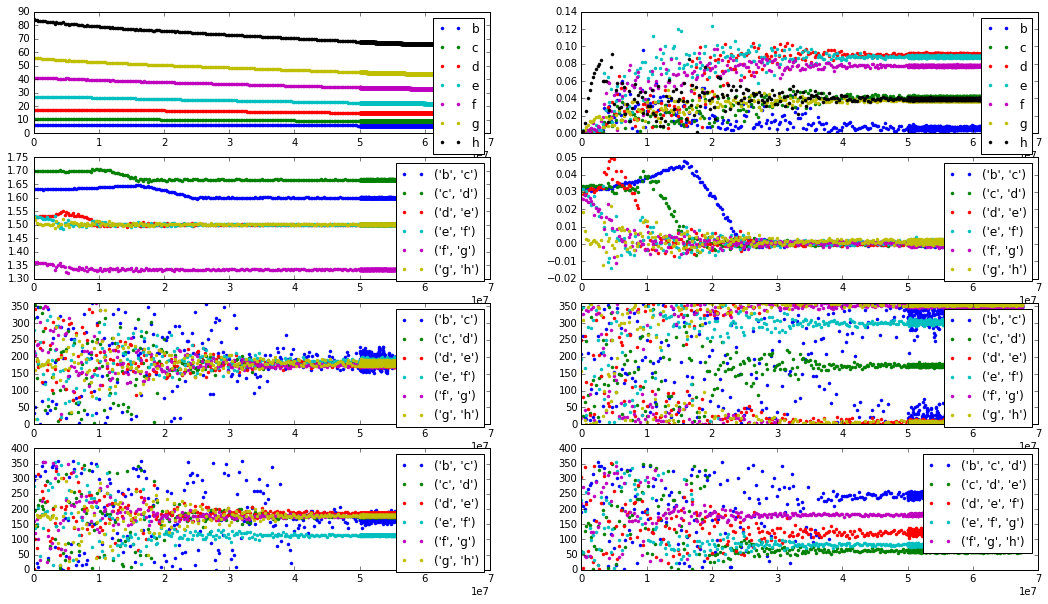

In [75]:
Tremoval = 5 # number of taue0s over which to remove damping
removedamping(sim, Tremoval, K, planets,resonances,threebodyresonances,outputs)
plot(planets,resonances,threebodyresonances,outputs);

In [76]:
seed(simID)
assert_approx_equal(K, 10**uniform(1,3), 4, "simID did not generate same value of K as in ic") # get new random number after K
mag = 10**uniform(-3,0)
print(mag)

Mstar = 0.08
sim2 = rebound.Simulation()
sim2.G = 4*np.pi**2
sim2.add(m=Mstar)

Pd = 4.0496/365.25

mscale = Mstar/sim.particles[0].m
Pscale = Pd/sim.particles['d'].P

ps = sim.particles
for p in planets: 
    r = uniform(-1,1)
    sign = abs(r)/r # get +/- 1 randomly
    sim2.add(m=ps[p].m*mscale, P=ps[p].P*Pscale, e=ps[p].e*(1. + sign*mag), inc=ps[p].inc, pomega=ps[p].pomega, Omega=ps[p].Omega, theta=ps[p].theta, hash=p)

sim2.move_to_com()

0.2186534714057171


In [77]:
sim = sim2
ps = sim.particles
sim.integrator="whfast"
sim.dt=ps[1].P*0.07

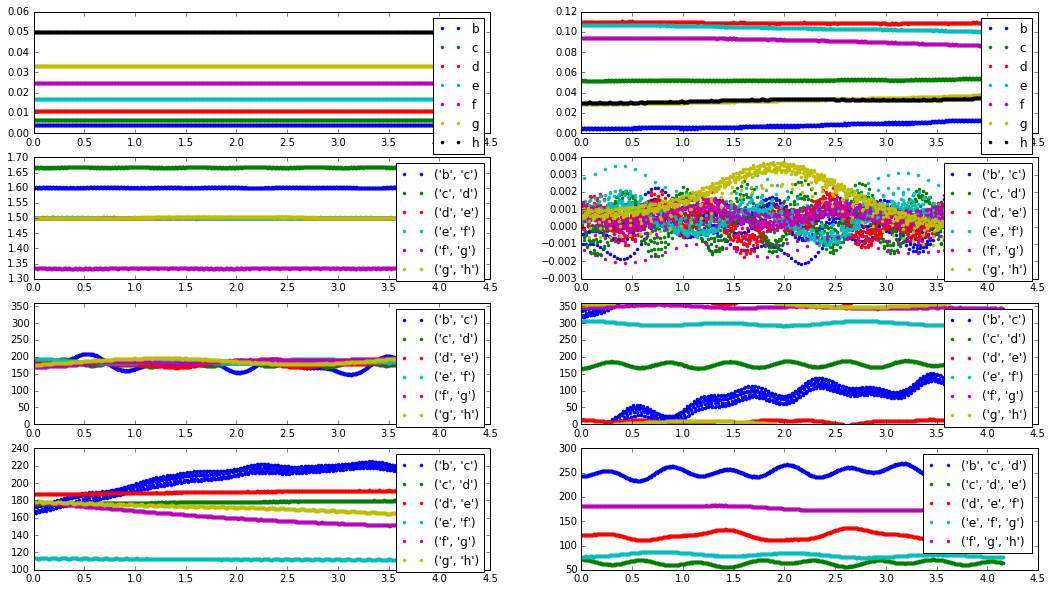

In [78]:
outputs = initialize(planets, resonances, threebodyresonances)
  
integrate(sim, 1.e3*ps[1].P, planets, resonances, threebodyresonances,outputs)
plot(planets,resonances,threebodyresonances,outputs);

726.3 0.013919007466


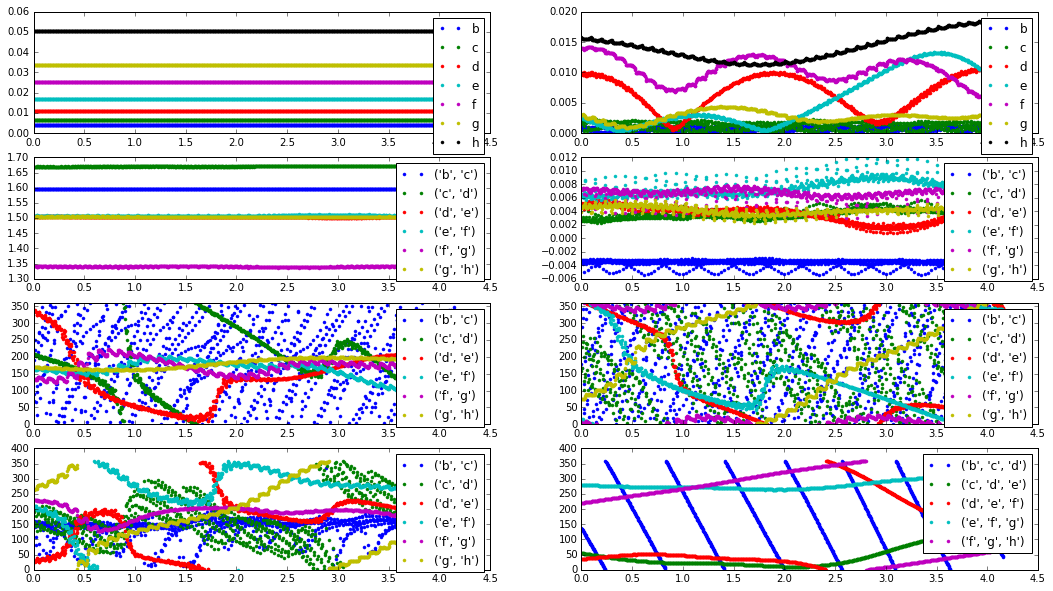

In [86]:
df = pd.read_csv("../data.csv", index_col=0)
ic = df.iloc[67]
print(ic['K'], ic['mag'])
sa = rebound.SimulationArchive('data/'+ic['filename'])
sim = sa[0]
outputs = initialize(planets, resonances, threebodyresonances)
  
integrate(sim, 1.e3*ps[1].P, planets, resonances, threebodyresonances,outputs)
plot(planets,resonances,threebodyresonances,outputs);